In [1]:
%matplotlib inline

In [21]:
!ls /vision/group/ntu-rgbd/zane/work_dirs/support_50_few_shot_nturgbd_swin_tiny_rgb.py

20220220_205950.log	  20220220_210836.log.json
20220220_205950.log.json  20220220_212921.log
20220220_210253.log	  20220220_212921.log.json
20220220_210253.log.json  epoch_10.pth
20220220_210334.log	  epoch_1.pth
20220220_210334.log.json  epoch_5.pth
20220220_210655.log	  latest.pth
20220220_210655.log.json  support-set-few-shot-fine-tune-config.py
20220220_210836.log


In [25]:
!ls /vision/group/ntu-rgbd/zane/work_dirs/support_50_few_shot_nturgbd_swin_tiny_depth.py # Change to support

20220220_214709.log	  20220220_215113.log.json
20220220_214709.log.json  epoch_10.pth
20220220_214837.log	  epoch_15.pth
20220220_214837.log.json  epoch_5.pth
20220220_215013.log	  latest.pth
20220220_215013.log.json  support-set-few-shot-fine-tune-depth-config.py
20220220_215113.log


In [41]:
WORK_DIR = '/vision/group/ntu-rgbd/zane/work_dirs/'

files = [
    WORK_DIR + 'support_50_few_shot_nturgbd_swin_tiny_rgb.py/20220220_212921.log.json', 
    WORK_DIR + 'support_50_few_shot_nturgbd_swin_tiny_depth.py/20220220_215113.log.json',
]

legend = ['rgb', 'depth']
metric = 'loss' #, 'top1_acc', 'top5_acc']
# Size of dataset 
dataset_size = 50
step_size = 5 # num examples in each step
num_gpus = 2

In [42]:
# Iterations reset at the end of the epoch
from collections import defaultdict
iter2times = defaultdict(lambda:0) # keeps track of how many times each iter has been seen

def reset_iters():
    iter2times.clear()

def get_real_iter(i):
    val = dataset_size * iter2times[i] + i * num_gpus
    iter2times[i] += 1
    return val

In [43]:
import numpy as np
import json
steps = []
for line in open(files[1], 'r'):
    steps.append(json.loads(line))

modes = []
for step in steps[1:]:
    if step['mode'] == 'val':
        print(step)

{'mode': 'val', 'epoch': 2, 'iter': 250, 'lr': 0.0, 'memory': 8173, 'data_time': 0.25834, 'top1_acc': 0.302, 'top5_acc': 0.72, 'loss_cls': 2.53555, 'loss': 2.53555, 'time': 0.58941}
{'mode': 'val', 'epoch': 4, 'iter': 250, 'lr': 0.0, 'memory': 8175, 'data_time': 0.02772, 'top1_acc': 0.726, 'top5_acc': 0.964, 'loss_cls': 0.90045, 'loss': 0.90045, 'time': 0.36542}
{'mode': 'val', 'epoch': 6, 'iter': 250, 'lr': 0.0, 'memory': 8175, 'data_time': 0.01015, 'top1_acc': 0.724, 'top5_acc': 0.986, 'loss_cls': 0.98619, 'loss': 0.98619, 'time': 0.34697}
{'mode': 'val', 'epoch': 8, 'iter': 250, 'lr': 0.0, 'memory': 8175, 'data_time': 0.0099, 'top1_acc': 0.732, 'top5_acc': 0.982, 'loss_cls': 0.90834, 'loss': 0.90834, 'time': 0.34579}
{'mode': 'val', 'epoch': 10, 'iter': 250, 'lr': 0.0, 'memory': 8175, 'data_time': 0.01032, 'top1_acc': 0.774, 'top5_acc': 0.982, 'loss_cls': 0.77689, 'loss': 0.77689, 'time': 0.34648}
{'mode': 'val', 'epoch': 12, 'iter': 250, 'lr': 0.0, 'memory': 8175, 'data_time': 0.01

In [44]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [45]:
modes = ['train', 'val']
key2data = {}
for file, key in zip(files, legend):
    steps = []
    for line in open(file, 'r'):
        steps.append(json.loads(line))
    mode2steps = {}
    for mode in modes:
        reset_iters()
        mode2steps[mode] = []
        if mode == 'train':
            mode2steps['iter'] = []           
            for s, step in enumerate(steps[1:]): # First step is env_info
                if step['mode'] == 'train':
                    mode2steps[mode].append(step[metric])
                    mode2steps['iter'].append(get_real_iter(step['iter']))

        elif mode == 'val':
            mode2steps['epoch'] = []
            for step in steps[1:]:
                if step['mode'] == 'val':
                    mode2steps[mode].append(step[metric])
                    mode2steps['epoch'].append(step['epoch'] * dataset_size)
    
    key2data[key] = mode2steps
        

plotting rgb
plotting train for rgb
plotting val for rgb
plotting depth
plotting train for depth
plotting val for depth


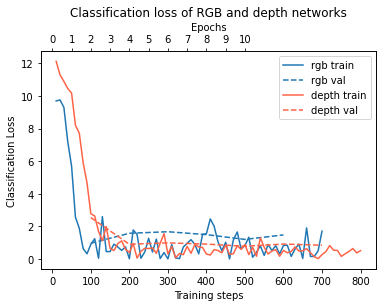

In [46]:
tr_colors = ['tab:blue', 'tomato']
val_colors = ['b', 'r'] # Needs to be same length as keys

for key, t_c, v_c in zip(key2data, tr_colors, val_colors):
    print("plotting", key)
    for mode in modes:
        print("plotting", mode, "for", key)
        if mode == 'train':
            # Added for smoothing
            # y_vals = savgol_filter(key2data[key][mode], 51, 5)
            y_vals = key2data[key][mode]
            plt.plot(key2data[key]['iter'], y_vals, label=key + ' train', zorder=1, c=t_c)
            plt.legend()
        elif mode == 'val':
            y_vals = key2data[key][mode]
            #plt.scatter(key2data[key]['epoch'], y_vals, s=100, c=v_c, marker='o', zorder=2) # Create circles
            plt.plot(key2data[key]['epoch'], y_vals, label=key + ' val', zorder=1, linestyle='dashed', c=t_c)
            plt.legend()
            plt.legend()

axes1 = plt.gca()
axes2 = axes1.twiny()
num_epochs = 10
new_tick_locs = [dataset_size*i for i in range(num_epochs + 1)]
axes2.set_xlim(axes1.get_xlim())
axes2.set_xticks(new_tick_locs)
axes2.set_xticklabels([i for i in range(num_epochs + 1)])
axes2.set_xlabel("Epochs")
axes1.set_xlabel("Training steps")
axes1.set_ylabel("Classification Loss")
#axes1.legend(legend)
plt.savefig('visualization.png')
plt.title('Classification loss of RGB and depth networks')
plt.show()

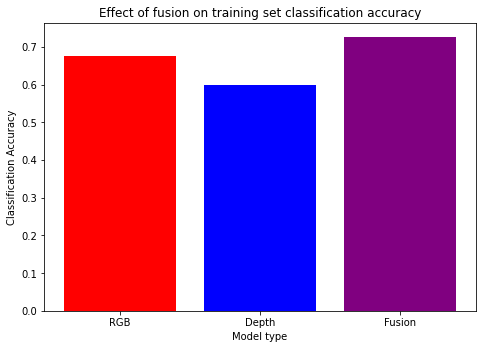

In [111]:
# Next step: visualize on validation set
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['RGB', 'Depth', 'Fusion']
students = [.676,.599,.728]
ax.bar(langs,students, color=['r', 'b', 'purple'])
ax.set_xlabel("Model type")
ax.set_ylabel("Classification Accuracy")
ax.set_title("Effect of fusion on training set classification accuracy")
plt.show()